In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## Classificateur de Bayes Naïf sur des **variables discrètes** 

**La Formule de Bayes** pour des **variables discrètes** :  

  
$$ P(Y | X_1, X_2,...,X_n) = \frac{P(X_1, X_2,...,X_n | Y) . P(Y)}{P(X_1, X_2,...,X_n)} $$  

avec $P(X_1, X_2,...,X_n) =  \sum_{c∈\mathcal{Y}} P(X_1, X_2,...,X_n | Y=c). P(Y=c) = \sum_{c∈\mathcal{Y}} (\prod_{i}^{n}P(X_i| Y=c)). P(Y=c) $_  

<blockquote>
    Note : On peut se dispenser du dénominateur $P(X_1, X_2,...,X_n)$ car c'est une constante identique pour chaque classe $Y=c$
</blockquote> 
 
On a alors la **proportionnalité** suivante :  
$$ P(Y | X_1, X_2,...,X_n) \propto P(X_1, X_2,...,X_n | Y). P(Y) $$  

Pour une **facilité dans les calculs**, on applique le **logarithme** à la formule de Bayes :  

$$ \log P(Y | X_1, X_2,...,X_n) = \log (P(X_1, X_2,...,X_n | Y) . P(Y)) = \log (P(X_1, X_2,...,X_n | Y) ) + \log(P(Y)) $$

Le classifieur de Bayes est un modèle naïf car on va supposer que nos variables $X_i$ sont "i.i.d." **(indépendantes et identiquement distribuées)** afin d'obtenir la fonction de **Vraisemblance** $V(X)$ suivante :
$$ V(X) = P(X_1, X_2,...,X_n | Y) = \prod_{i=1}^{n} P(X_i = x | Y = y) = \prod_{i=1}^{n} \frac{N_{x,y} + \alpha}{N_y + 2.\alpha}$$  

*avec :*  
- $N_{x,y}$ : Nombre d'occurences où $X_i = x$ et $Y=y$  
- $N_y$ : Nombre d'occurences où $Y=y$
- $\alpha$ : Coefficient du **lissage de Laplace** à définir. C'est une constante qui évite les probabilités nulles au cas où $N_{x,y} = 0$, ainsi que des divisions par zéro si $N_y=0$
    
On applique désormais le **logarithme** à la formule de Bayes pour plus de rapidité dans les calculs *(produits --> somme)*.  
On obtient la fonction de **log-Vraisemblance** $L(X)$ suivante :  
$$ L(X) = \log(V(X)) = \log \prod_{i=1}^{n} P(X_i = x| Y=y) = \sum_{i=1}^{n} \log(P(X_i=x | Y=y)) $$  

  
Pour **prédire** la classe $Y$ d'une variable en entrée, on va calculer $P(Y | X_1, X_2,...,X_n)$ pour **chaque classe** $y$ puis garder la classe qui a la **probabilité la plus grande** :  
$$ ŷ = \underset{y}{argmax}[P(Y | X_1, X_2,...,X_n)] = \underset{y}{argmax}[L(X) + \log(P(Y))]$$


 

### Import du dataset MNIST

In [3]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

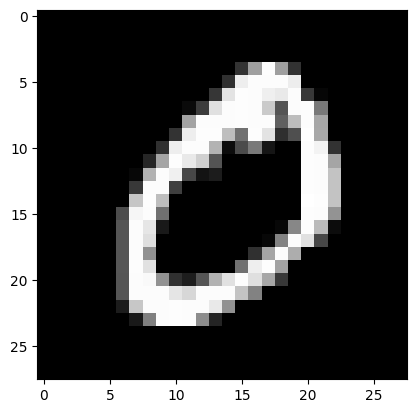

In [6]:
plt.imshow(x_train[1], cmap="gray")   # cmap="gray" pour échelle de gris

#### Vectorisation de nos chiffres manuscrits
- Une Image : matrice (28x28)
- Une image vectorisée = vecteur (784x1)

In [12]:
# On transforme chaque image en vecteur de taille (784 x 1)
X_train = x_train.reshape(-1, 28*28)
X_test = x_test.reshape(-1, 28*28)

#### On "binarise" nos données pour que chaque pixel vaille 0 ou 1 (noir ou blanc) pour faire simple.
<blockquote>
    Ainsi, chaque pixel suivra une loi de Bernoulli
</blockquote>

In [13]:
# Si un pixel > limit_barrier, alors on le met à 1.
limit_barrier = 110

X_train_binary  = (X_train.copy() > limit_barrier).astype(int)
X_test_binary = (X_test.copy() > limit_barrier).astype(int)

##### Les images vont apparaître sans différentes nuances de gris pour simplifier la classification

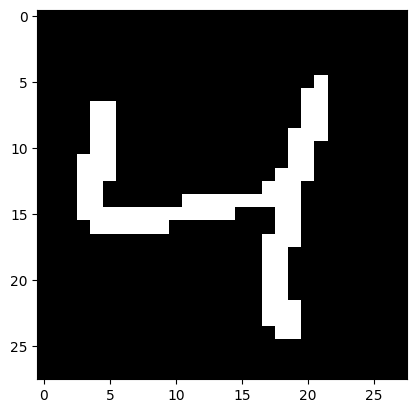

In [16]:
plt.imshow((x_train[y_train == 4] > limit_barrier).astype(int)[0], cmap='gray')

Comme dans notre code, on part du principe que chaque pixel est binaire (noir ou blanc / 0 ou 1).  
Pour une image $X$, on obtient sa **log-vraisemblance** avec ce calcul compact :  

$$ L(X) = \sum_{i=1}^{n} \biggl[ x_i.\log P(X_i = 1 | Y = y) + (1-x_i). \log (1 - P(X_i = 1 | Y = y)) \biggl] $$   

avec $n$ : la taille de notre image à prédire (taille du vecteur)


Si le pixel $X_i$ vaut $x_i=1$, alors on calcule :
- $\log P(X_i = 1 | Y = y) $

Si le pixel $X_i$ vaut $x_i=0$, on aura dans la somme:  
- $ \log (1 - P(X_i = 1 | Y = y)) =  \log P(X_i = 0 | Y = y)$


##### Code du classifieur de Bayes pour des variables discrètes

In [5]:
def Bayes_naif_discrete(X_train, Y_train, X_test, alpha):

    predictions = []          # Va contenir les prédictions de chaque image
    freq_uns = [] # tableau des différents vecteurs contenants les fréquences d'apparition des pixels = 1 en fonction de chaque classe Y.
    len_total = np.sum(Y_train)        # Longueur totale du dataset d'entraînement ~ 10k
    lenghts_per_classes = []           # Longueur du jeu de données en fonction de chaque classe Y


    # On simplifie les calculs en calculant à l'avance la fréquence des pixels=1 et les longueurs car ils sont fixes
    for c in np.unique(Y_train):
        count_uns = np.sum(X_train[Y_train == c], axis=0) + alpha  # Comptage des pixels=1 pour la classe Y=c + Lissage de Laplace
        
        Nc = np.sum(Y_train == c)    # Taille du vecteur Y_train == c
        lenghts_per_classes.append(Nc) 
        
        freq_uns.append(count_uns / (Nc + 2*alpha) )    
    
    # Pour chaque image "x" du dataset "X_test" on exécute notre classfieur de Bayes Naïf
    for x in X_test:          
        tab_probas = np.zeros((len(np.unique(Y_train)))) # Tableau contenant les probas d'appartenance à Y={1,...,9} pour une image
        
        for c in np.unique(Y_train):
            prior = lenghts_per_classes[c] / len_total # P(Y = c)
            
            likelihood = np.sum(x * np.log(freq_uns[c]) + (1 - x)*np.log(1 - freq_uns[c]))   # log-Vraisemblance : P(X1, X2,...,Xn | Y)            
            
            tab_probas[c] = likelihood + np.log(prior)  # Le passage au logarithme simplifie les calculs : produits -> sommes
            
        predictions.append(np.argmax(tab_probas))   # Prédiction = l'index de la probabilité d'appartenance la plus élevée

    return predictions

In [55]:
pred_bernoulli = Bayes_naif_discrete(X_train_binary, y_train, X_test_binary, alpha=1e-5)

In [56]:
print("Accuracy : ", accuracy_score(pred_bernoulli, y_test))

Accuracy :  0.8472


## Classificateur de Bayes Naïf sur des **variables continues** 

**La Formule de Bayes** pour des **variables continues** en utilisant la fonction de **densité de la loi normale** en guise de **Vraisemblance** :  

  
$$ P(Y | X_1, X_2,...,X_n) = \frac{f_{X| Y=y}(x) . P(Y)}{P_X(X_1, X_2,...,X_n)} = \frac{Vraisemblance. P(Y)}{P(X_1, X_2,...,X_n)} $$  

_avec $P(X_1, X_2,...,X_n) = \sum_{y} f_{X | Y=y}(x) .P(Y)$_  
  
*Note : On peut se dispenser du dénominateur $f_{X}(x)$ car c'est une constante identique pour chaque classe $Y=y$*  
 
On a alors la **proportionnalité** suivante :  
$$ f_{Y | X=x}(y) \propto f_{X| Y=y}(x) . P(Y) $$  

Pour une **facilité dans les calculs**, on applique le **logarithme** à la formule de Bayes :  

$$ \log f_{Y=y| X}(x) = \log (f_{X| Y=y}(x) .  P(Y)) = \log (f_{X| Y=y}(x)) + \log(P(Y)) $$

On suppose que nos données sont "i.i.d." **(indépendantes et identiquement distribuées)** et sont **distribuées selon une loi normale** de paramètres $\mu$ et $\sigma$.  
Soit $f(X, \mu, \sigma)$ la **fonction de densité** de la loi normale telle que :  
$$ f(X, \mu, \sigma) = \frac{1}{\sigma.\sqrt{2.\pi}}.e^{-\frac{1}{2}.\frac{(X - \mu)^2}{\sigma^2}}$$

On obtient la fonction de **Vraisemblance** $V(X, \mu, \sigma)$ suivante :  

$$ V(X, \mu, \sigma)  = f_{X| Y=y}(x) = \prod_{i=1}^{n}f_{X_i| Y=y}(x) = \prod_{i=1}^{n}f(x_i, \mu, \sigma) $$
*avec n : le nombre de variables*  

On applique désormais le logarithme à la formule de Bayes pour une rapidité dans les calculs.  
On obtient la fonction de **log-Vraisemblance** $L(X, \mu, \sigma)$ suivante :  
$$ L(X, \mu, \sigma) = \log(V(X, \mu, \sigma)) = \log \prod_{i=1}^{n}f(x_i, \mu, \sigma) = \sum_{i=1}^{n} \log(f(x_i, \mu, \sigma)) =  \sum_{i=1}^{n} \log \biggl(\frac{1}{\sigma.\sqrt{2.\pi}}.e^{-\frac{1}{2}.\frac{(X_i - \mu)^2}{\sigma^2}} \biggl)$$  

*Après simplification on obtient :*  
$$ L(X, \mu, \sigma) = \sum_{i=1}^{n} \biggl[ -\log(\sigma) - \log(\sqrt{2.\pi}) - \frac{1}{2}.\biggl(\frac{X_i - \mu}{\sigma}\biggl)^2 \biggl]$$
  
Pour **prédire** la classe $Y$ d'une variable en entrée, on va calculer $f_{Y | X=x}(y)$ pour **chaque classe** $y$ puis garder la classe qui a la **probabilité la plus grande** :  
$$ ŷ = argmax_y[P(Y | X_1, X_2,...,X_n)] $$ 
$$ = \underset{y}{argmax} [L(X, \mu, \sigma) + \log( P(Y))]$$


 

##### Code log - Vraisemblance

In [6]:
def log_likelihood(mu, sigma, X):
    return np.sum(-np.log(sigma) - np.log(np.sqrt(2*np.pi)) - 0.5*((X - mu)/sigma)**2)

##### Code du classifieur de Bayes naïf pour des variables continues

In [17]:
def Bayes_naif_continue(X_train, Y_train, X_test):

    predictions = np.zeros(len(X_test))

    log_priors = {}
    mu = {}
    sigma = {}
    for c in np.unique(Y_train):
        log_priors[c] = np.log(len(Y_train[Y_train == c]) / len(Y_train))
        mu[c] = np.mean(X_train[Y_train == c], axis=0)
        sigma[c] = np.std(X_train[Y_train == c], axis=0) + 1   # Variance Smoothing

    for i in range(len(X_test)) :
        
        array_probas = np.zeros(len(np.unique(Y_train)))
        for j in np.unique(Y_train):
            likelihood = log_likelihood(mu[j], sigma[j], X_test[i])
            array_probas[j] = likelihood + log_priors[j]

        predictions[i] = np.argmax(array_probas)

    return predictions

In [18]:
predictions = Bayes_naif_continue(X_train, y_train, X_test)

On a un score plus faible que le classifieur de Bayes pour des variables discrètes car, ici, on suppose que chaque pixel suit une distribution Gaussienne alors que ce n'est pas le cas.

In [19]:
print("Accuracy : ", accuracy_score(predictions, y_test))

Accuracy :  0.6742


## Génération d'images 

#### Tirage de chaque pixel avec seuil

In [23]:
chiffre = 0

count_uns = np.sum(X_train_binary[y_train == chiffre], axis=0) + 1e-6 
Nc = np.sum(y_train == chiffre)   
probas_chiffre_zeros = count_uns / (Nc + 2*1e-6)

image = (probas_chiffre_zeros > 0.5).astype(int)   # Si la frequence/proba est strictement supérieur à 0.5, alors pixel=1 ; sinon 0
image = image.reshape(28, 28)

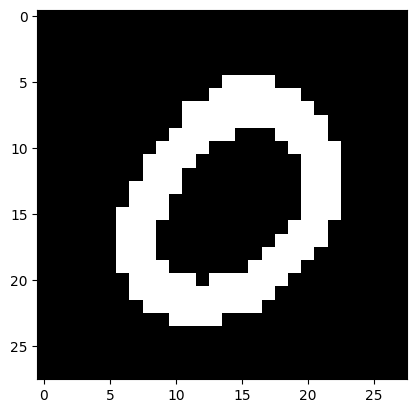

In [24]:
plt.imshow(image, cmap='gray')

#### Tirage aléatoire de chaque pixel suivant la loi de Bernoulli suivie par chaque pixel

In [25]:
def generer_image(vecteur_frequence_chiffre):
    image = np.array([np.random.binomial(1, vecteur_frequence_chiffre[i]) for i in range(len(vecteur_frequence_chiffre))])
    return image.reshape(28, 28)

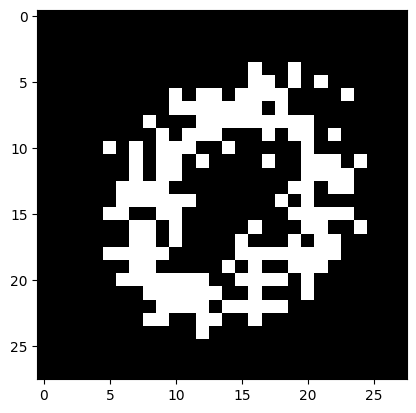

In [201]:
plt.imshow(generer_image(probas_chiffre_zeros), cmap='gray')

#### Tirage des chiffres en suivant une distribution normale 

In [43]:
chiffre = 3

In [44]:
mu = np.mean(X_train[y_train == chiffre], axis=0)
sigma = np.std(X_train[y_train == chiffre], axis=0)

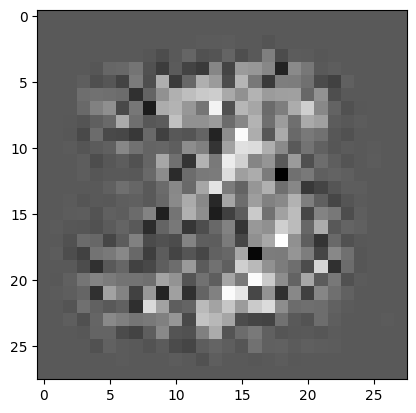

In [45]:
plt.imshow(np.random.normal(mu, sigma).reshape(28, 28), cmap='gray')

#### Image plus détérministe
##### On fait la même chose que ci-dessus, mais si un pixel tiré, selon nos paramètres mu et sigma, a une valeur > 140, alors le pixel vaut 1. Sinon 0.
##### Il n'y a aucune nuance de gris dans l'image.


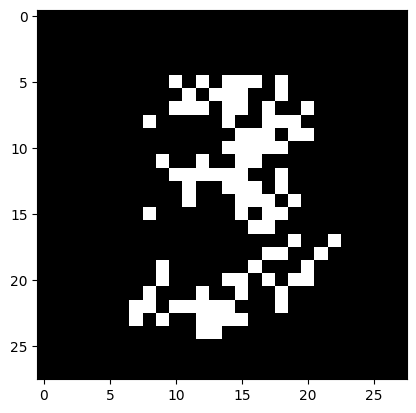

In [48]:
plt.imshow(
    # Si un pixel tiré, selon nos paramètres mu et sigma, est > 140, alors le pixel vaut 1. Sinon 0. -> Aucune nuance de gris.
    (np.random.normal(mu, sigma)>140).astype(int).reshape(28, 28), 
    cmap='gray'
)